#### 이상탐지 메트릭
- 불균형 데이터셋: Precision, Recall, F1 score 추천 (PR curve)
- 균형 데이터 셋: AUC 추천
- 

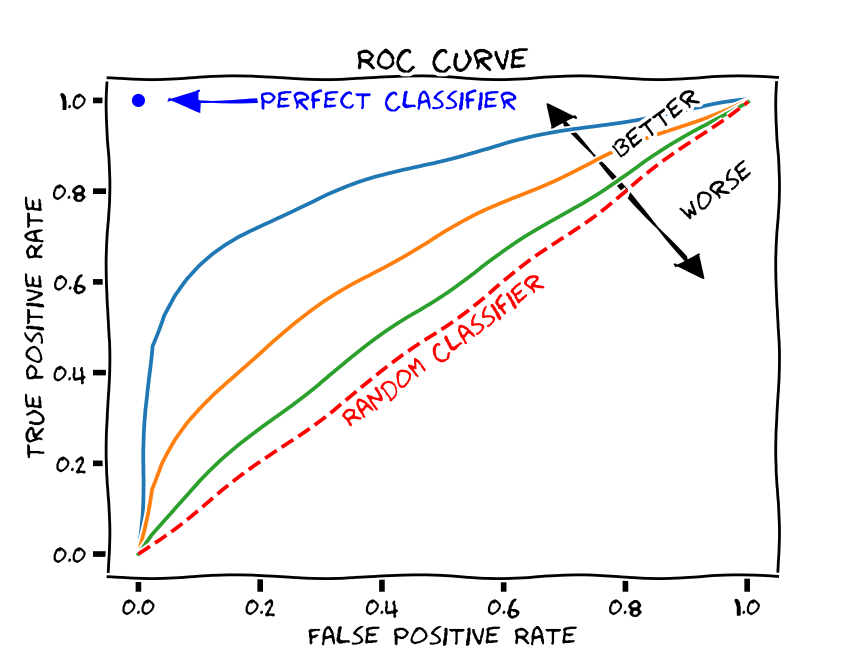

#### 불균형 데이터셋: Precision, Recall, F1 score 추천 (PR curve)
- Precision = 옳게 예측된 양성 수/예측 양성 수 = TP/(TP+FP)  
→ 클수록, 1에 가까울수록 좋음!
- Recall = 옳게 예측된 양성 수/실제 양성 수 = TPR = TP/(TP+FN)  
→ 클수록, 1에 가까울수록 좋음!
- F1 score = 2PR/(P+R) = P와 R의 조화평균
- ('조화평균을 이용하면 산술평균을 이용하는 것보다, 큰 비중이 끼치는 bias가 줄어든다고 볼 수 있음')
  
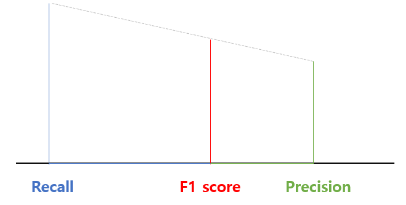

#### 균형 데이터 셋: AUC 추천
- FPR = 잘못 예측된 음성 수/실제 음성 수 = FP/(FP+TN) → 작을수록, 0에 가까울수록 좋음!
- TPR = 옳게 예측된 양성 수/실제 양성 수 = Recall = TP/(TP+FN) → 클수록, 1에 가까울수록 좋음!
  - FPR, TPR을 라벨과 점수로 계산할 수 있다.

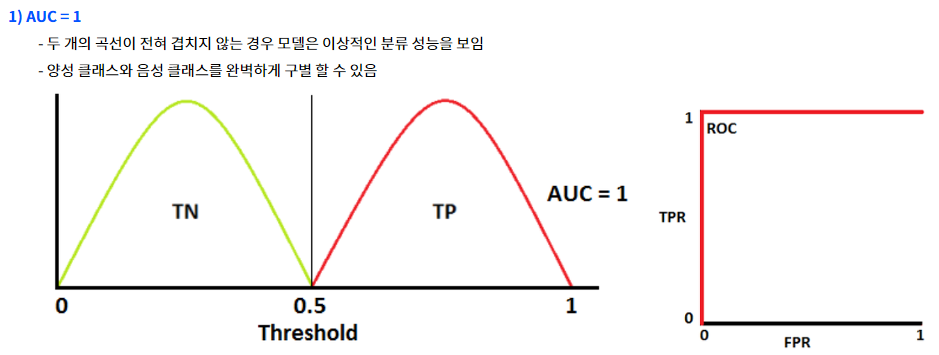

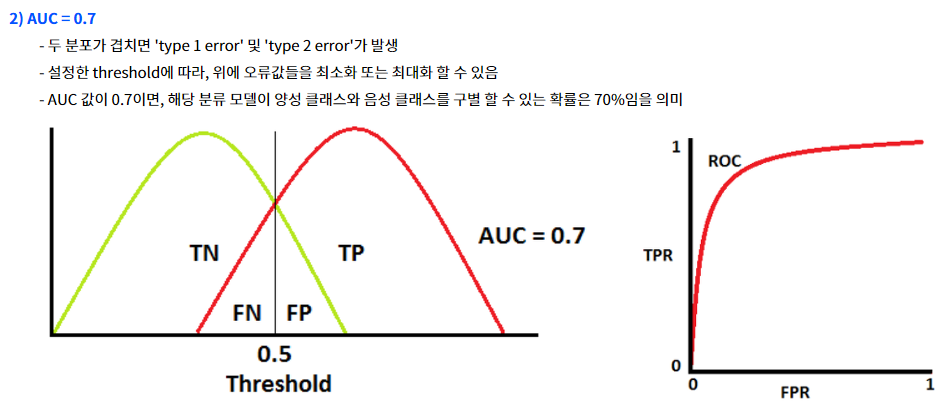

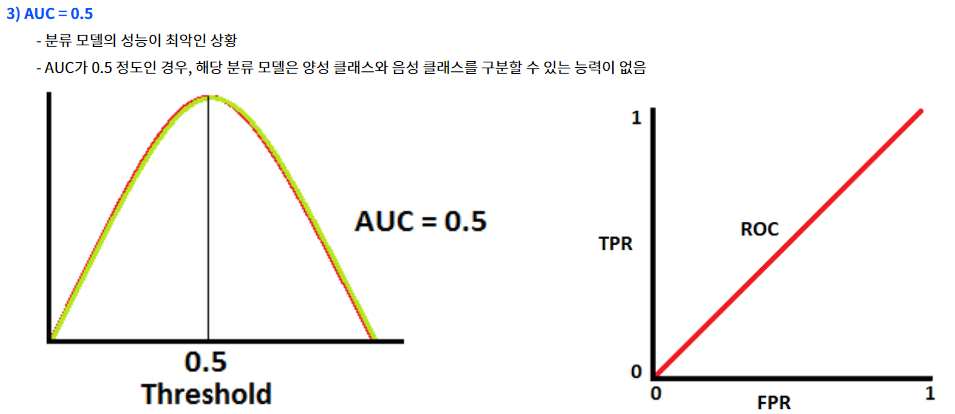

<번외>
- Balanced (모델이 두 클래스를 얼마나 잘 구분하는가) → Imbalanced (소수 클래스를 얼마나 탐지해낼 수 있는가)
- ROC curve와 F1 score에서 Recall을 동일하게 사용하므로, 유일한 차이는 FPR을 사용하는가 or Precision을 사용하는가의 차이임. '식에서도 볼 수 있듯 FPR은 Total Negatives 가 분모로 존재하기 때문에 총 Negative Class의 수가 FPR값에 큰 영향을 미친다. 즉 Imblanaced Dataset에서는 Negative 클래스인 0 클래스 수가 1클래스 수에 비해 워낙 많은 상황이기 때문에 False Positive의 수가 개선되더라도 FPR 값이 줄기 쉽지 않다. 반면 Precision은 전체 negative class 수에 전혀 영향을 받지 않게 된다. 따라서 FPR을 활용하는 AUC스코어보다는 F1 Score를 활용하여 학습한 뒤 PR Curve를 통해 모델의 성능을 검증하는 것이 좋다'.
Precision: 클래스 1에 대해 정확하게 탐지할 수 있는 확률
FPR, TPR: 클래스를 분간하는 능력을 지표화

- fpt, tpr은 sklearn의 roc_curve(gt_list, img_scores)로 구할 수 있고,
- 면적 또한 sklearn의 roc_auc_score(gt_list, img_scores)로 구할 수 있다.
- f1_score는 
    - precision, recall, thresholds = precision_recall_curve(gt_list, img_scores) 로 부터
    - precision, recall을 구한 다음에 구할 수 있다.

#### sklearn.metrics.roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None, drop_intermediate=True)
- Receiver operating characteristic (ROC) 계산
- 해당 구현은 2진 분류에만 한정되어 있다.
<입력>  
- y_true: 만약 라벨이{-1, 1}, {0, 1}이 아니라면, pos_label은 주어져야 한다.
- y_score: 양성 클래스의 확률 추정지
<출력>  
- fpr (ndarray of shape (>2,)): 오탐율 score >= thrdshols[i]

임계값은 낮은 값에서 높은 값으로 정렬되므로 (계산 중에 역순으로 정렬되는) fpr 및 tpr에 모두 해당하는지 확인하기 위해 `반환 시 역순으로 정렬`됩니다.

`곡선이 (0, 0)에서 시작하도록 보장하기 위해 tpr=0 및 fpr=0인 경우에 임의의 임계값이 추가됩니다`.
이 임계값은 np.inf에 해당합니다.

In [1]:
import numpy as np
from sklearn import metrics

y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
print('fpr: ', fpr)
print('tpr: ', tpr)
print('thresholds: ', thresholds)

fpr:  [0.  0.  0.5 0.5 1. ]
tpr:  [0.  0.5 0.5 1.  1. ]
thresholds:  [ inf 0.8  0.4  0.35 0.1 ]


#### sklearn.metrics.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)
- ROC의 아래 영역 계산
- 해당 구현은 `이진, 다중 클래스, 멀티 라벨` 모두에도 적용 가능하다. 

In [ ]:
def calculate_max_f1(gt, scores):
    precision, recall, thresholds = precision_recall_curve(gt, scores)
    a = 2 * precision * recall
    b = precision + recall
    f1s = np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    index = np.argmax(f1s) # 가장 높은 f1 점수 인덱스??
    max_f1 = f1s[index] 
    threshold = thresholds[index] # 가장 높은 f1 점수 일때의 thresholds?
    return max_f1, threshold

def metric_cal(scores, gt_list, gt_mask_list, cal_pro=False):
    '''
    scores: 모델 출력 값
    gt_list: 라벨 값{-1, 1} 혹은 {0, 1}, 이미지의 경우 이상(anomaly) GT 마스크
    
    Q. gt_list와 gt_mask_list 차이는????
    '''
    # calculate image-level ROC AUC score
    img_scrore = scores.reshape(scores.shape[0], -1).max(axis=1)
    gt_list = np.asarray(gy_list, dtype=int)
    
    fpr, tpr, _ = roc_curve(gt_list, img_scores)
    img_roc_auc = roc_auc_score(gt_list, img_scores)

    img_f1, img_threshold = calculate_max_f1(gt_list, img_scores)

    # calculate per-pixel level ROCAUC
    fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
    per_pixel_roc_auc = roc_auc_score(gt_mask.flatten(), scores.flatten())

    if cal_pro:
        pro_auc_score = cal_pro_metric(gt_mask_list, scores, fpr_thres=0.3)
        # calculate max-f1 region
        max_f1_region = calculate_max_f1_region(gt_mask_list, scores)
    else:
        pro_auc_score = 0
        # calculate max-f1 region
        max_f1_region = 0

    result_dict = {'i_roc': img_roc_auc * 100,
                   'p_roc': per_pixel_rocauc * 100,
                   'i_f1': img_f1 * 100,
                   'p_f1': pxl_f1 * 100,
                   'p_pro': pro_auc_score * 100,   # 주로 0
                   'r_f1': max_f1_region * 100 # 주로 0
                   }
    return result_dict    

In [4]:
from sklearn.metrics import roc_auc_score

# 실제 타깃값
true_labels = [0, 1, 0, 1]

# 모델의 예측 확률
predicted_probabilities = [0.1, 0.9, 0.3, 0.5]

# ROC AUC 점수 계산
auc_score = roc_auc_score(true_labels, predicted_probabilities)
print("ROC AUC 점수:", auc_score)

ROC AUC 점수: 1.0
